# 1. Import Libraries

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 2. Load the MNIST Dataset

In [194]:
# MNIST contains 28x28 grayscale images of handwritten digits (0-9)
(X_full, y_full), (X_test, y_test) = mnist.load_data()

In [195]:
# Display shapes of the original datasets
print("Full training data shape:", X_full.shape)  # (60000, 28, 28)
print("Test data shape:", X_test.shape)           # (10000, 28, 28)

Full training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [196]:
print(X_full[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [197]:
print(y_full[0])

5


# 3. Data Analysis (Before Splitting)

## 3.1 Class Distribution

In [198]:
unique, counts = np.unique(y_full, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution in full training set:", class_distribution)

Class Distribution in full training set: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [199]:
class_distribution

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

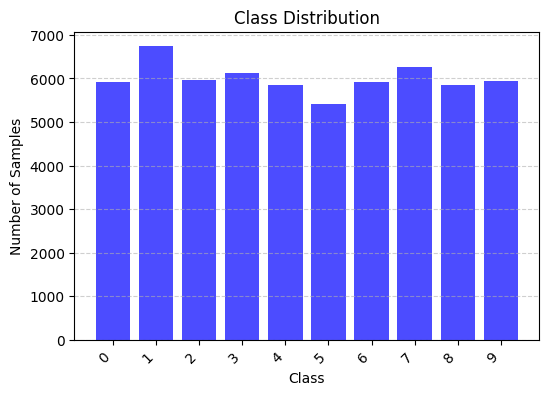

In [200]:
import matplotlib.pyplot as plt

unique, counts = np.unique(y_full, return_counts=True)

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color="blue", alpha=0.7)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(unique, rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## 3.2 Basic Statistics

In [201]:
import numpy as np

print("Data type of X_train:", X_full.dtype)
print("Min pixel value:", np.min(X_full))
print("Max pixel value:", np.max(X_full))
print("Unique classes in y_train:", np.unique(y_full))

print("Mean pixel value:", np.mean(X_full))
print("Standard deviation of pixel values:", np.std(X_full))

Data type of X_train: uint8
Min pixel value: 0
Max pixel value: 255
Unique classes in y_train: [0 1 2 3 4 5 6 7 8 9]
Mean pixel value: 33.318421449829934
Standard deviation of pixel values: 78.56748998339798


## 3.3 Visualization: Show one sample per digit

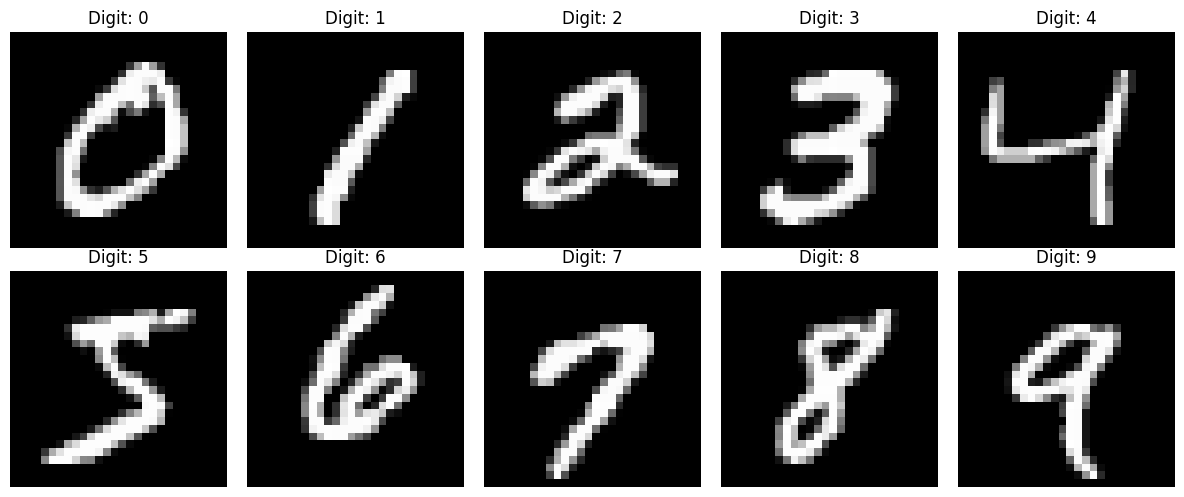

In [202]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for digit in range(10):
    idx = np.where(y_full == digit)[0][0]  # take the first occurrence for each digit
    ax = axes[digit // 5, digit % 5]
    ax.imshow(X_full[idx], cmap='gray')
    ax.set_title(f"Digit: {digit}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# 4. Data Splitting and Preprocessing

In [203]:
# Split full training data into training (80%) and validation (20%) sets (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=0
)

In [204]:
print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Labels: {y_test.shape}")


Training set shape: (48000, 28, 28), Labels: (48000,)
Validation set shape: (12000, 28, 28), Labels: (12000,)
Test set shape: (10000, 28, 28), Labels: (10000,)


In [205]:
# Normalize the images so that pixel values are scaled to the range [0, 1]
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm   = X_val.astype('float32')   / 255.0
X_test_norm  = X_test.astype('float32')  / 255.0

In [206]:
print("Training set mean after normalization:", np.mean(X_train_norm))
print("Training set std after normalization:", np.std(X_train_norm))

Training set mean after normalization: 0.13051748
Training set std after normalization: 0.3079375


In [207]:
# Flatten images to 2D arrays (num_samples x 784) for classifier inputs
X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_val_flat   = X_val_norm.reshape(X_val_norm.shape[0], -1)
X_test_flat  = X_test_norm.reshape(X_test_norm.shape[0], -1)
print("Flattened training data shape:", X_train_flat.shape)

Flattened training data shape: (48000, 784)


In [208]:
X_train_flat.shape

(48000, 784)

In [209]:
X_val_flat.shape

(12000, 784)

In [210]:
X_test_flat.shape

(10000, 784)

In [211]:
y_train.shape

(48000,)

In [212]:
y_val.shape

(12000,)

In [213]:
y_test.shape

(10000,)

In [214]:
# Optionally, apply StandardScaler to further standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled   = scaler.transform(X_val_flat)
X_test_scaled  = scaler.transform(X_test_flat)

In [215]:
X_train_scaled.shape

(48000, 784)

In [216]:
X_train_flat.shape

(48000, 784)

In [217]:
X_train_scaled[0]


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.93957335e-03, -6.43411046e-03, -4.56440216e-03, -4.56440216e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.56440216e-03, -5.26560610e-03, -6.23781001e-03, -1.05900271e-02,
       -1.57673415e-02, -2.01009717e-02, -2.40446944e-02, -2.72517540e-02,
       -2.89194845e-02, -3.06205042e-02, -3.21105309e-02, -3.05025373e-02,
       -3.08413394e-02, -2.79082377e-02, -2.34699491e-02, -2.00512726e-02,
       -1.76167246e-02, -1.22565571e-02, -8.11294932e-03, -4.56440216e-03,
        0.00000000e+00,  

In [218]:
X_train_flat[0]

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

----

# Explanation: X_train_flat vs. X_train_scaled

- **X_train_flat:**
  - **Normalized and Flattened:** The images are first normalized so that pixel values are in the range [0, 1].
  - **Flattened:** Each 28×28 image is reshaped into a 1D array of 784 features.
  - **Usage:** This format is used for algorithms that require 2D input (samples × features).

- **X_train_scaled:**
  - **Based on X_train_flat:** It starts with the normalized and flattened data.
  - **Standardized:** A `StandardScaler` is applied to the flattened data, which standardizes each feature by subtracting the mean and dividing by the standard deviation computed on the training data.
  - **Result:** Each feature in `X_train_scaled` has a mean of 0 and a standard deviation of 1, which can improve the performance of many machine learning models.
---

- May be acceptable if you rely solely on StandardScaler to standardize the data, but combining an initial normalization step (to [0, 1]) with flattening can often improve the performance and convergence of many models.

# which one should we prefer?

X_train_flat = X_train.reshape(X_train.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flat)


- # or,


X_train_norm = X_train.astype('float32') / 255.0

X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flat)




## The recommended approach is to first normalize the pixel values and then flatten the images before applying standardization. In other words, I should use:


X_train_norm = X_train.astype('float32') / 255.0

X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flat)



Reasons:

- Normalization to [0, 1]:
Dividing by 255.0 scales the pixel values into a consistent range ([0, 1]). This is important for neural data like images, where pixel intensities originally range from 0 to 255. It reduces the effect of differing scales and helps improve numerical stability.

- Flattening after Normalization:
Once the images are normalized, flattening them maintains the benefits of normalization by ensuring each pixel is within the same range.

- Standardization Benefits:
Applying the StandardScaler after normalization further centers the data (mean of 0) and scales it (unit variance). This can improve the performance of many algorithms, especially those sensitive to feature scaling (like k‑NN).

- Overall Impact:
Normalizing before standardization generally leads to better model convergence and performance because it ensures that the data is on a similar scale before further statistical transformation.

# 5. k-NN Classifier

## 5.1 Hyperparameter Tuning: Try different k values

In [219]:
k_values = [1, 3, 5, 7, 9]
val_accuracies = []

In [220]:
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    y_val_pred = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)
    print(f"k = {k} -> Validation Accuracy: {acc:.4f}")

k = 1 -> Validation Accuracy: 0.9453
k = 3 -> Validation Accuracy: 0.9457
k = 5 -> Validation Accuracy: 0.9456
k = 7 -> Validation Accuracy: 0.9440
k = 9 -> Validation Accuracy: 0.9439


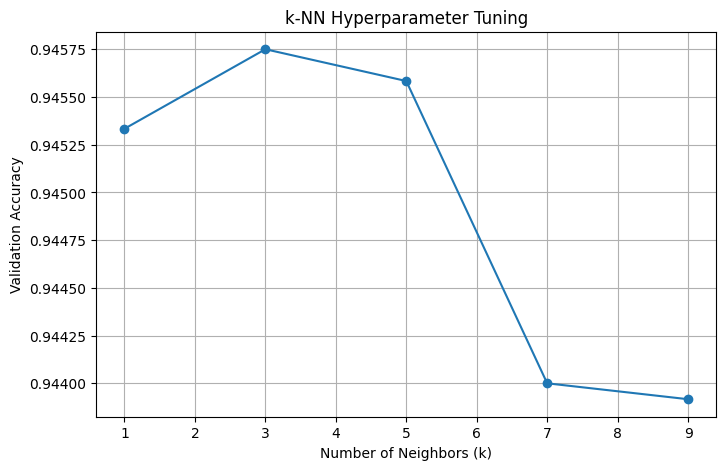

In [221]:
# Plot validation accuracy versus number of neighbors
plt.figure(figsize=(8, 5))
plt.plot(k_values, val_accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("k-NN Hyperparameter Tuning")
plt.grid(True)
plt.show()

In [222]:
# Select the best k based on highest validation accuracy
best_index = np.argmax(val_accuracies)
best_k = k_values[best_index]
print(f"Best k value: {best_k} with Validation Accuracy: {val_accuracies[best_index]:.4f}")


Best k value: 3 with Validation Accuracy: 0.9457


## 5.2 Final Model Training and Evaluation on Test Set

In [223]:
# Combine training and validation sets for final training
X_train_final = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_final = np.concatenate((y_train, y_val), axis=0)

final_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
final_knn.fit(X_train_final, y_train_final)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [224]:
# Evaluate on test set
y_test_pred_knn = final_knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"k-NN Test Accuracy: {accuracy_knn:.4f}")
print("Classification Report for k-NN:")
print(classification_report(y_test, y_test_pred_knn))

k-NN Test Accuracy: 0.9451
Classification Report for k-NN:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.95      0.99      0.97      1135
           2       0.95      0.94      0.94      1032
           3       0.92      0.95      0.94      1010
           4       0.95      0.94      0.95       982
           5       0.93      0.93      0.93       892
           6       0.97      0.96      0.97       958
           7       0.94      0.93      0.93      1028
           8       0.96      0.90      0.93       974
           9       0.93      0.92      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.95      0.94     10000



In [225]:
# Confusion Matrix Visualization
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
print("Confusion Matrix for k-NN:")
print(cm_knn)


Confusion Matrix for k-NN:
[[ 967    0    1    3    0    4    5    0    0    0]
 [   0 1127    3    0    1    0    3    0    1    0]
 [  12    9  967   15    2    0    5   11    9    2]
 [   0    4    5  963    2   14    0   12    8    2]
 [   1    9    5    2  922    2    7    4    3   27]
 [   7    0    5   22    4  828    9    2    7    8]
 [  14    4    2    0    3    9  924    0    2    0]
 [   0   22   12    4    7    2    0  953    1   27]
 [  15    3   10   24   10   22    3    7  873    7]
 [   5    6    6   11   16    7    0   28    3  927]]


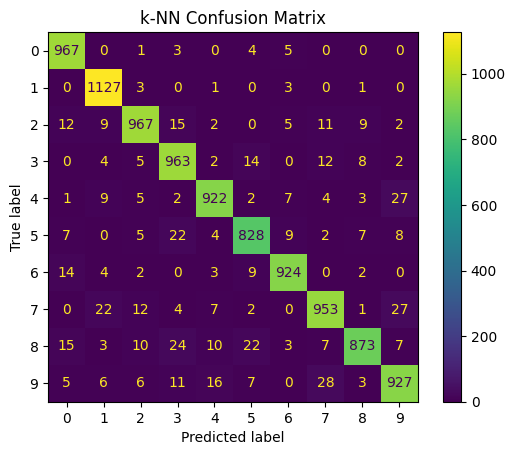

In [226]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_knn)
plt.title("k-NN Confusion Matrix")
plt.show()

Total misclassified examples: 549


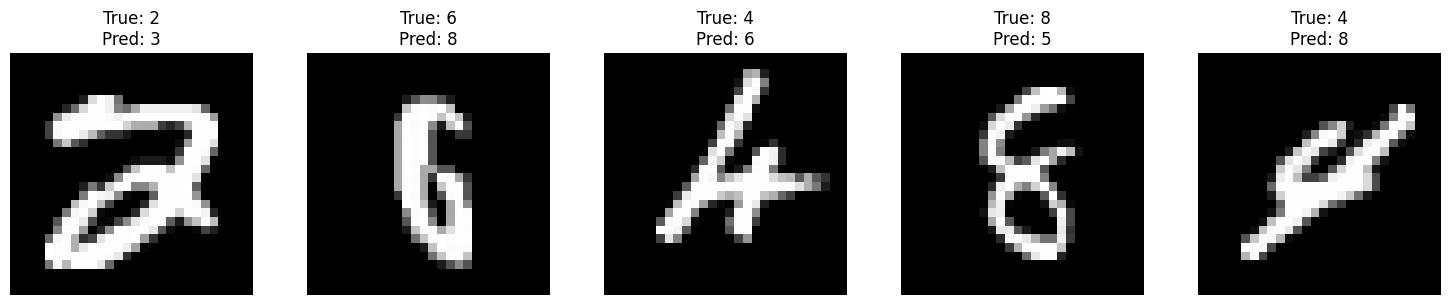

In [227]:
# Display 5 random misclassified examples
misclassified_idx = np.where(y_test != y_test_pred_knn)[0]
print("Total misclassified examples:", len(misclassified_idx))
if len(misclassified_idx) >= 5:
    sample_indices = np.random.choice(misclassified_idx, size=5, replace=False)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        ax.imshow(X_test_norm[idx], cmap='gray')
        ax.set_title(f"True: {y_test[idx]}\nPred: {y_test_pred_knn[idx]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# 6. Decision Tree Classifier

## 6.1 Hyperparameter Tuning using GridSearchCV

In [228]:
param_grid = {
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5]
}

In [229]:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy'
)

In [230]:
grid_search.fit(X_train_final, y_train_final)
print("Best Hyperparameters for Decision Tree:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.8501


## 6.2 Final Model Training and Evaluation on Test Set

In [231]:
best_tree = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
best_tree.fit(X_train_final, y_train_final)
y_test_pred_tree = best_tree.predict(X_test_scaled)
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_test_pred_tree))

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.85      0.84      0.84      1032
           3       0.82      0.84      0.83      1010
           4       0.86      0.85      0.86       982
           5       0.84      0.80      0.82       892
           6       0.91      0.87      0.89       958
           7       0.90      0.88      0.89      1028
           8       0.80      0.81      0.80       974
           9       0.81      0.86      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000



In [232]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree)
print("Confusion Matrix for Decision Tree:")
print(cm_tree)

Confusion Matrix for Decision Tree:
[[ 918    0   10    8    6   11    7    4   13    3]
 [   1 1089   12   13    2    5    2    1   10    0]
 [  15   11  864   20   22    8   12   34   35   11]
 [   7    5   39  845    6   47    2   19   23   17]
 [   3    4    7    7  832    7   12    8   28   74]
 [  16    9    5   51   14  716   20    8   30   23]
 [  23    5   13    7   34   17  833    3   21    2]
 [   2   14   26   10   10    5    0  906   11   44]
 [   9   10   30   40   14   21   19    9  791   31]
 [  13    2    8   32   24   14    5   13   31  867]]


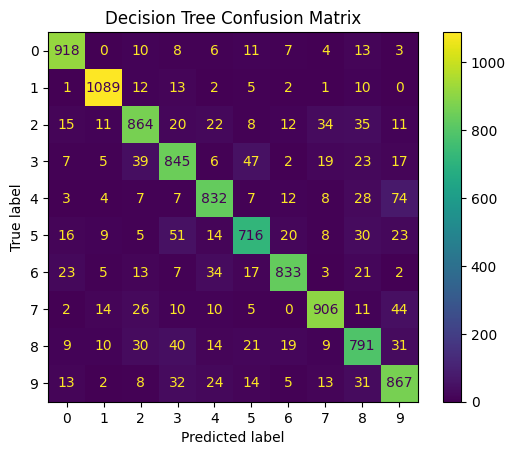

In [233]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_tree)
plt.title("Decision Tree Confusion Matrix")
plt.show()

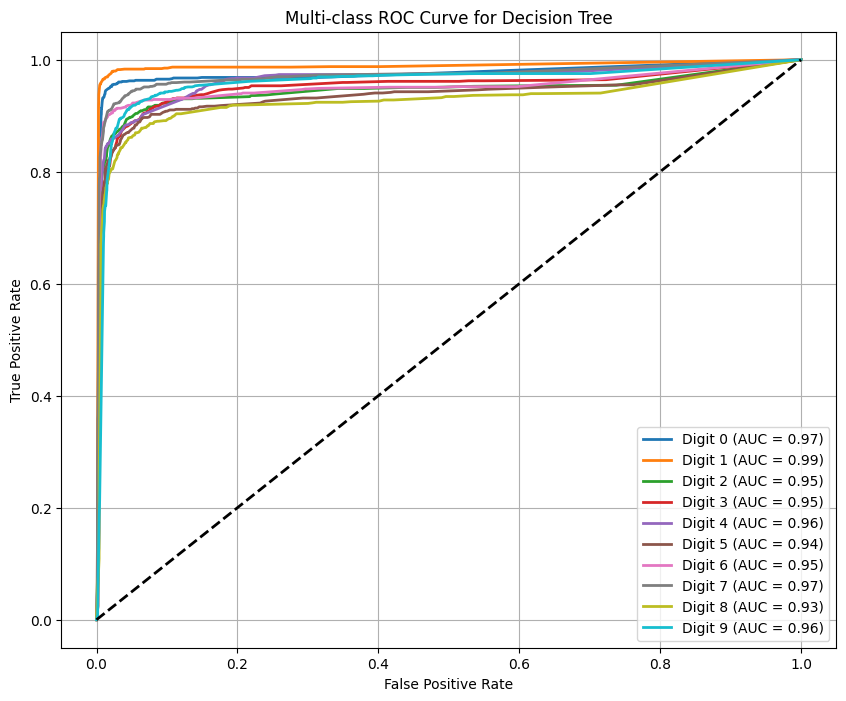

In [234]:
# Plot ROC Curve for each digit (multi-class ROC)
# Note: DecisionTreeClassifier provides predict_proba, which we use for ROC computation.
y_test_proba_tree = best_tree.predict_proba(X_test_scaled)
# Binarize the true labels for multi-class ROC calculation
y_test_bin = label_binarize(y_test, classes=np.arange(10))
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba_tree[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Digit {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve for Decision Tree")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

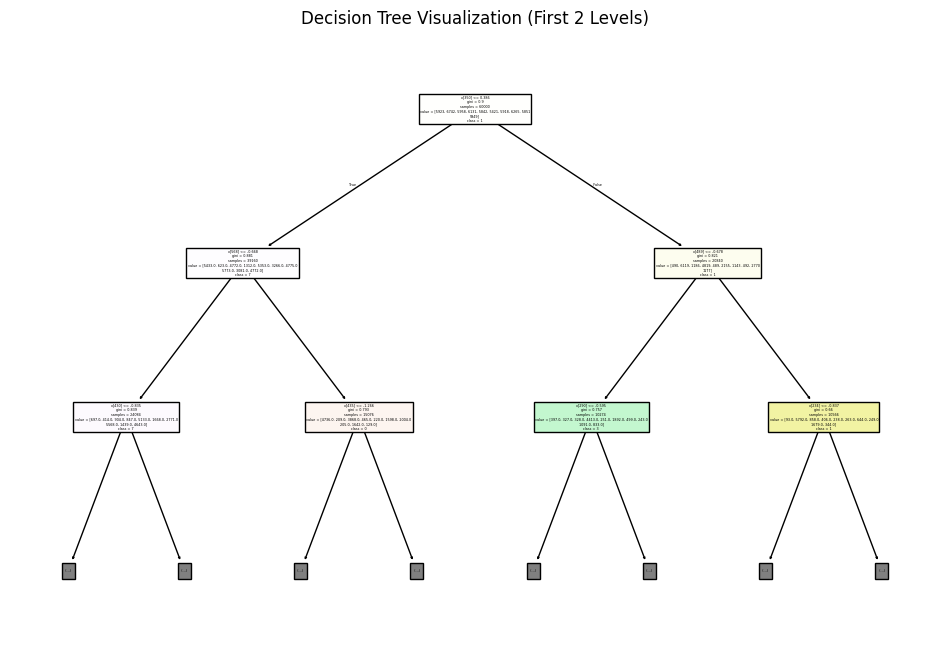

In [235]:
# Visualize the decision tree (only a few levels for readability)
plt.figure(figsize=(12, 8))
plot_tree(best_tree, filled=True, class_names=[str(i) for i in range(10)], max_depth=2)
plt.title("Decision Tree Visualization (First 2 Levels)")
plt.show()

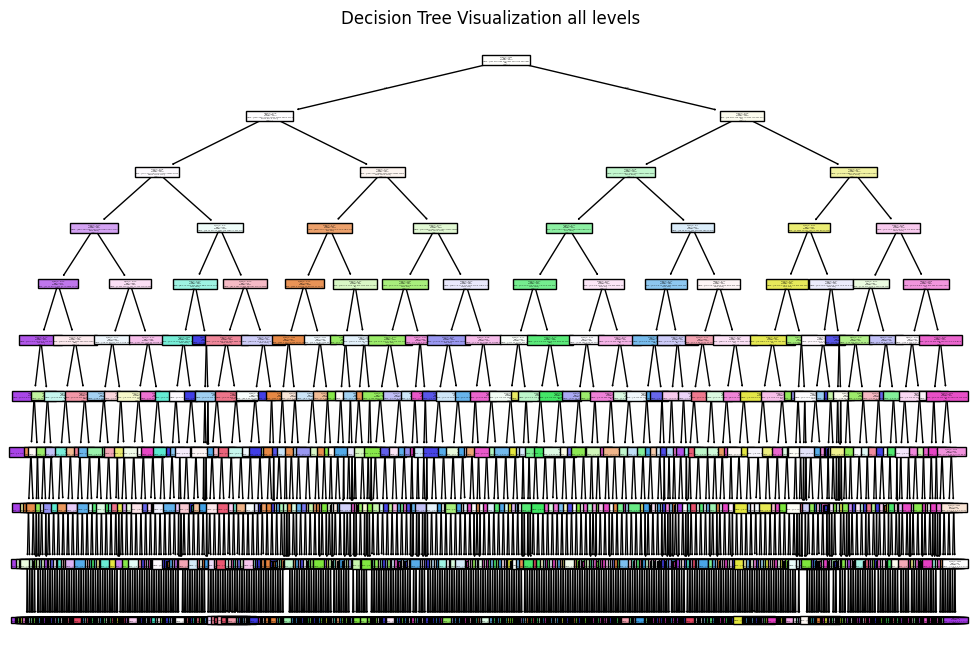

In [236]:
# Optional: Visualize the decision tree (only a few levels for readability)
plt.figure(figsize=(12, 8))
plot_tree(best_tree, filled=True, class_names=[str(i) for i in range(10)])
plt.title("Decision Tree Visualization all levels")
plt.show()